## Importing libraries

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, GCNConv, SAGEConv # Graph Neural Network 
from torch_geometric.nn import global_mean_pool 
import rpy2.robjects as robjects # load R object 
from rpy2.robjects import pandas2ri # load R object 
from tqdm import tqdm # print progress bar 
import pickle # save object 
import matplotlib.pyplot as plt
import numpy as np
import random as rd 
import pandas as pd

In [10]:
import os

current_directory = os.getcwd()
#print("Current working directory:", current_directory)


os.chdir( "/Users/oasc/Documents/Thesis/ML_phylogeny_learning")


Load trees and corresponding target parameters and convert them to pandas data.frame

In [12]:
pandas2ri.activate()

#fname_graph = "data/phylogeny-DDD-nt-1e+05-la0-0.5-1.5-mu-0.05-0.5-k-10-20-age-15-ddmod-1-graph.rds"
#fname_param = "data/true-param-DDD-nt-1e+05-la0-0.5-1.5-mu-0.05-0.5-k-10-20-age-15-ddmod-1.rds"

fname_graph = "data_clas/phylogeny_re-all-graph.rds"
fname_param = "data_clas/phylo-true-clas-all2.rds"

readRDS = robjects.r['readRDS']
df_graph = readRDS(fname_graph)
df_graph = pandas2ri.rpy2py(df_graph)
df_param = readRDS(fname_param)
df_param = pandas2ri.rpy2py(df_param)


#df_param[2] = df_param[2]/100
#df_param[3] = df_param[3]/100

#removing crown age from predictions
#df_param = df_param[0:3]


# Simulating Indices

In [13]:
import random

preselected_sets = False
subset_size = 40000 # Specify the size of the subset
file_of_index = "data/10_3_indices_set_-DDD-Totalset-10000-SubSiz-10000-.rds" # to use the same as R

if preselected_sets == True:
    ind = readRDS(file_of_index) 
    ind = pandas2ri.rpy2py(ind)

    train, valid, test = ind
    train_ind, valid_ind, test_ind = list(train), list(valid), list(test)
    #print(train_ind[1])
    train_ind, valid_ind, test_ind = [i-1 for i in train_ind], [i-1 for i in valid_ind], [i-1 for i in test_ind]
    #print(train_ind[1])

else:
    #total_data_points = len(df_graph)
    total_data_points = 40000
    subset_size = 40000-1  # Specify the size of the subset

    n_train = int(subset_size * 0.9)
    n_valid = int(subset_size * 0.05)
    n_test = subset_size - n_train - n_valid
    batch_size = min(int(subset_size * 0.01), 10)

    # Pick the phylogenies randomly.
    #true[2] = true[2] / 100
    #true[3] = true[3] / 100
    #ds = convert_encode_to_dataset(cblv, true)

    # Pick the random subset of data points.
    subset_indices = random.sample(range(1, total_data_points), subset_size)

    # Split the subset into train, validation, and test indices.
    train_ind = subset_indices[:n_train]
    valid_ind = subset_indices[n_train:(n_train + n_valid)]
    test_ind = subset_indices[(n_train + n_valid):subset_size]

Checking the total number of trees of the dataset (n_trees) and the number of target parameters for each tree (n_param)

In [14]:
n_param = len(df_param)
n_trees = len(df_graph)

In [15]:
def convert_df_to_tensor(df_node, df_edge, params):

    """
    Convert the data frames containing node and edge information 
    to a torch tensor that can be used to feed neural 
    """

    n_node, n_edge = df_node.shape[0], df_edge.shape[0]
    #n_node, n_edge = int(robjects.r("nrow")(df_node)[0]), int(robjects.r("nrow")(df_edge)[0])

    #pandas_df_node = pd.DataFrame(df_node)
    #pandas_df_edge = pandas2ri.ri2py_dataframe(df_edge)

    l1, l2 = [], []
    
    for i in range(n_edge):
        #print(type(pandas_df_node))
        edge = df_edge.iloc[i]
        u, v = edge[0]-1, edge[1]-1
        l1 = l1 + [u,v]
        l2 = l2 + [v,u]

    edge_index = torch.tensor([l1,l2], dtype=torch.long)

    x = []

    for i in range(n_node):
        node_attr = list(df_node.iloc[i])
        x.append(node_attr)

    x = torch.tensor(x, dtype = torch.float)

    y = torch.tensor(params, dtype = torch.float)

    data = Data(x = x, edge_index = edge_index, y = y)

    return(data)

# Preparing data for training

In [16]:
batch_size_max = 64
data_list  = []

for n in tqdm(range(40000)):
    df_node, df_edge = df_graph[n][0], df_graph[n][1]
    params = [df_param[i][n] for i in range(n_param)]
    data = convert_df_to_tensor( pandas2ri.rpy2py(df_node), pandas2ri.rpy2py(df_edge), params)
    data_list.append(data)

#dataloader = DataLoader(data_list, batch_size=batch_size_max)

  0%|          | 0/40000 [00:00<?, ?it/s]

100%|██████████| 40000/40000 [43:44<00:00, 15.24it/s]  


Save or load dataset

In [17]:
fname_param[:-9]

'data_clas/phylo-true-clas'

In [18]:
save = True

fname = fname_param[:-9] + "geomtensor" + ".obj" # file name 
if (save):
    print("Save")
    file = open(fname, "wb") # file handler 
    pickle.dump(data_list, file) # save data_list

else:
    print("Load")
    file = open(fname, "rb")
    data_list = pickle.load(file) 

Save


In [5]:
print("Load")
file = open(fname, "rb")
data_list = pickle.load(file) 

Load


NameError: name 'fname' is not defined

Split dataset into train, valid and test set.

In [263]:
print(data_list[2999].y)

tensor([0., 1., 0., 0.])


In [19]:
#device = "cuda:2" # GPU to use 
device="cpu"
batch_size_max = 32


train_data = [data_list[i].to(device=device) for i in train_ind]
valid_data = [data_list[i].to(device=device) for i in valid_ind]
test_data  = [data_list[i].to(device=device) for i in test_ind]

train_dl = DataLoader(train_data, batch_size = batch_size_max, shuffle = True)
valid_dl = DataLoader(valid_data, batch_size = batch_size_max, shuffle = True)
test_dl  = DataLoader(test_data , batch_size = 1)

Create the GNN structure

In [20]:
class GCN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.conv1 = GCNConv(n_in, n_hidden)
        self.conv2 = GCNConv(n_hidden, n_hidden)
        self.conv3 = GCNConv(n_hidden, n_hidden)
        self.conv4 = GCNConv(n_hidden, n_hidden)
        self.conv5 = GCNConv(n_hidden, 2*n_hidden)
        self.lin1  = torch.nn.Linear(2*n_hidden, n_hidden)
        self.lin2  = torch.nn.Linear(n_hidden, n_out)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p = 0.5, training=self.training)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = self.lin2(x)
        return x

In [21]:
def train(model, batch):
    optimizer.zero_grad()
    out = model(batch)
    batch_size = int(max(data.batch) + 1) # number of trees in the batch 
    loss = F.cross_entropy(out, data.y.reshape([batch_size, n_out])) # compute loss 
    loss.backward() # backward propagation 
    optimizer.step()
    acc=torch.sum(torch.argmax(data.y.reshape([batch_size, n_out]),axis=1)==torch.argmax(out,dim=1)).item()
    return(loss,acc/batch_size)

def valid(model, batch):
    out = model(batch)
    batch_size = int(max(data.batch) + 1) # number of trees in the batch 
    loss = F.cross_entropy(out, data.y.reshape([batch_size, n_out])) # compute loss
    acc=torch.sum(torch.argmax(data.y.reshape([batch_size, n_out]),axis=1)==torch.argmax(out,dim=1)).item()
    #total = out.size(dim=0)
    return(loss,acc/batch_size)


In [245]:
data_list[1000].num_node_features


6

In [25]:
# Setting up the training 
n_in = data_list[0].num_node_features
n_out = len(data_list[0].y)
n_hidden = 100
n_epochs = 100
model = GCN(n_in, n_hidden, n_out).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = F.cross_entropy

file_path = 'data_clas/models/GNN_phylo_class.pt'

# Save the model


In [28]:

valid_list = []
train_list = []

train_acc_list = []
valid_acc_list = []


patience = 10  # Number of epochs to wait for improvement
best_loss = float('inf')
best_epoch = 0

early_stop = False
counter = 0



# Training loop 

for epoch in range(n_epochs):
    if early_stop:
        break

    # Training
    model.train()
    train_loss = []
    train_acc = []
    for data in tqdm(train_dl):
        loss , acc = train(model, data)  # train model and get loss
        loss = float(loss.to(device="cpu"))
        train_loss.append(loss)
        train_acc.append(acc)
    mean_loss = np.mean(train_loss)
    mean_acc = np.mean(train_acc)

    train_list.append(mean_loss)
    train_acc_list.append(mean_acc)

    print("Epoch %d - Train Loss : %.4f Train Acc : %.4f" % (epoch, float(mean_loss),float(mean_acc)))  # print progression

    # Validation
    model.eval()
    valid_loss = []
    valid_acc = []
    for data in tqdm(valid_dl):
        loss,acc = valid(model, data)  # train model and get loss
        loss = float(loss.to(device="cpu"))
        valid_loss.append(loss)
        valid_acc.append(acc)
    mean_loss = np.mean(valid_loss)
    mean_acc = np.mean(valid_acc)


    valid_list.append(mean_loss)
    valid_acc_list.append(mean_acc)
    print("Epoch %d - Valid Loss : %.4f Train Acc : %.4f" % (epoch, float(mean_loss),float(mean_acc)))  # print progression

    # Check for early stopping
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_epoch = epoch
        counter = 0
        torch.save(model.state_dict(), file_path)
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping at epoch %d" % (epoch))
            early_stop = True

print("Best epoch:", best_epoch)

100%|██████████| 1125/1125 [13:43<00:00,  1.37it/s]


Epoch 0 - Train Loss : 6.8932 Train Acc : 0.4008


100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 0 - Valid Loss : 6.8880 Train Acc : 0.4233


100%|██████████| 1125/1125 [15:25<00:00,  1.22it/s]


Epoch 1 - Train Loss : 6.8883 Train Acc : 0.4076


100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch 1 - Valid Loss : 6.8935 Train Acc : 0.4121


100%|██████████| 1125/1125 [15:53<00:00,  1.18it/s]


Epoch 2 - Train Loss : 6.8852 Train Acc : 0.4209


100%|██████████| 63/63 [00:27<00:00,  2.30it/s]


Epoch 2 - Valid Loss : 6.8922 Train Acc : 0.4127


100%|██████████| 1125/1125 [16:06<00:00,  1.16it/s]


Epoch 3 - Train Loss : 6.8851 Train Acc : 0.4229


100%|██████████| 63/63 [00:27<00:00,  2.31it/s]


Epoch 3 - Valid Loss : 6.8827 Train Acc : 0.4329


100%|██████████| 1125/1125 [16:20<00:00,  1.15it/s]


Epoch 4 - Train Loss : 6.8852 Train Acc : 0.4199


100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch 4 - Valid Loss : 6.8817 Train Acc : 0.4087


100%|██████████| 1125/1125 [15:58<00:00,  1.17it/s]


Epoch 5 - Train Loss : 6.8854 Train Acc : 0.4198


100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch 5 - Valid Loss : 6.8786 Train Acc : 0.4181


100%|██████████| 1125/1125 [15:43<00:00,  1.19it/s]


Epoch 6 - Train Loss : 6.8850 Train Acc : 0.4193


100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 6 - Valid Loss : 6.8791 Train Acc : 0.4211


100%|██████████| 1125/1125 [15:18<00:00,  1.22it/s]


Epoch 7 - Train Loss : 6.8838 Train Acc : 0.4267


100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch 7 - Valid Loss : 6.8843 Train Acc : 0.4314


100%|██████████| 1125/1125 [14:31<00:00,  1.29it/s]


Epoch 8 - Train Loss : 6.8842 Train Acc : 0.4252


100%|██████████| 63/63 [00:24<00:00,  2.62it/s]


Epoch 8 - Valid Loss : 6.8904 Train Acc : 0.4206


100%|██████████| 1125/1125 [14:17<00:00,  1.31it/s]


Epoch 9 - Train Loss : 6.8840 Train Acc : 0.4266


100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch 9 - Valid Loss : 6.8913 Train Acc : 0.4161


100%|██████████| 1125/1125 [14:16<00:00,  1.31it/s]


Epoch 10 - Train Loss : 6.8842 Train Acc : 0.4237


100%|██████████| 63/63 [00:23<00:00,  2.68it/s]


Epoch 10 - Valid Loss : 6.8811 Train Acc : 0.4177


100%|██████████| 1125/1125 [14:25<00:00,  1.30it/s]


Epoch 11 - Train Loss : 6.8845 Train Acc : 0.4212


100%|██████████| 63/63 [00:23<00:00,  2.65it/s]


Epoch 11 - Valid Loss : 6.8793 Train Acc : 0.4239


100%|██████████| 1125/1125 [14:12<00:00,  1.32it/s]


Epoch 12 - Train Loss : 6.8848 Train Acc : 0.4206


100%|██████████| 63/63 [00:23<00:00,  2.64it/s]


Epoch 12 - Valid Loss : 6.8835 Train Acc : 0.4298


100%|██████████| 1125/1125 [13:58<00:00,  1.34it/s]


Epoch 13 - Train Loss : 6.8844 Train Acc : 0.4215


100%|██████████| 63/63 [00:23<00:00,  2.71it/s]


Epoch 13 - Valid Loss : 6.8770 Train Acc : 0.4393


100%|██████████| 1125/1125 [14:08<00:00,  1.33it/s]


Epoch 14 - Train Loss : 6.8841 Train Acc : 0.4250


100%|██████████| 63/63 [00:24<00:00,  2.60it/s]


Epoch 14 - Valid Loss : 6.9125 Train Acc : 0.3803


100%|██████████| 1125/1125 [13:59<00:00,  1.34it/s]


Epoch 15 - Train Loss : 6.8851 Train Acc : 0.4214


100%|██████████| 63/63 [00:23<00:00,  2.67it/s]


Epoch 15 - Valid Loss : 6.8784 Train Acc : 0.4511


100%|██████████| 1125/1125 [13:55<00:00,  1.35it/s]


Epoch 16 - Train Loss : 6.8839 Train Acc : 0.4208


100%|██████████| 63/63 [00:23<00:00,  2.63it/s]


Epoch 16 - Valid Loss : 6.8931 Train Acc : 0.3952


100%|██████████| 1125/1125 [13:37<00:00,  1.38it/s]


Epoch 17 - Train Loss : 6.8855 Train Acc : 0.4241


100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


Epoch 17 - Valid Loss : 6.8915 Train Acc : 0.4147


100%|██████████| 1125/1125 [13:50<00:00,  1.35it/s]


Epoch 18 - Train Loss : 6.8842 Train Acc : 0.4217


100%|██████████| 63/63 [00:26<00:00,  2.40it/s]


Epoch 18 - Valid Loss : 6.8898 Train Acc : 0.4022


100%|██████████| 1125/1125 [13:51<00:00,  1.35it/s]


Epoch 19 - Train Loss : 6.8843 Train Acc : 0.4237


100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


Epoch 19 - Valid Loss : 6.8802 Train Acc : 0.4737


100%|██████████| 1125/1125 [13:44<00:00,  1.36it/s]


Epoch 20 - Train Loss : 6.8846 Train Acc : 0.4208


100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


Epoch 20 - Valid Loss : 6.8778 Train Acc : 0.4439


100%|██████████| 1125/1125 [13:42<00:00,  1.37it/s]


Epoch 21 - Train Loss : 6.8837 Train Acc : 0.4238


100%|██████████| 63/63 [00:26<00:00,  2.38it/s]


Epoch 21 - Valid Loss : 6.8812 Train Acc : 0.4483


100%|██████████| 1125/1125 [13:48<00:00,  1.36it/s]


Epoch 22 - Train Loss : 6.8844 Train Acc : 0.4242


100%|██████████| 63/63 [00:23<00:00,  2.72it/s]


Epoch 22 - Valid Loss : 6.8766 Train Acc : 0.4434


100%|██████████| 1125/1125 [13:39<00:00,  1.37it/s]


Epoch 23 - Train Loss : 6.8840 Train Acc : 0.4230


100%|██████████| 63/63 [00:23<00:00,  2.71it/s]


Epoch 23 - Valid Loss : 6.8782 Train Acc : 0.4317


100%|██████████| 1125/1125 [13:44<00:00,  1.36it/s]


Epoch 24 - Train Loss : 6.8837 Train Acc : 0.4223


100%|██████████| 63/63 [00:23<00:00,  2.64it/s]


Epoch 24 - Valid Loss : 6.8806 Train Acc : 0.4331


100%|██████████| 1125/1125 [13:40<00:00,  1.37it/s]


Epoch 25 - Train Loss : 6.8834 Train Acc : 0.4250


100%|██████████| 63/63 [00:22<00:00,  2.76it/s]


Epoch 25 - Valid Loss : 6.8857 Train Acc : 0.4244


100%|██████████| 1125/1125 [13:37<00:00,  1.38it/s]


Epoch 26 - Train Loss : 6.8846 Train Acc : 0.4231


100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


Epoch 26 - Valid Loss : 6.9097 Train Acc : 0.3505


100%|██████████| 1125/1125 [13:38<00:00,  1.38it/s]


Epoch 27 - Train Loss : 6.8844 Train Acc : 0.4233


100%|██████████| 63/63 [00:23<00:00,  2.68it/s]


Epoch 27 - Valid Loss : 6.8771 Train Acc : 0.4480


100%|██████████| 1125/1125 [13:45<00:00,  1.36it/s]


Epoch 28 - Train Loss : 6.8850 Train Acc : 0.4226


100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


Epoch 28 - Valid Loss : 6.8869 Train Acc : 0.4275


100%|██████████| 1125/1125 [13:50<00:00,  1.35it/s]


Epoch 29 - Train Loss : 6.8835 Train Acc : 0.4248


100%|██████████| 63/63 [00:23<00:00,  2.72it/s]


Epoch 29 - Valid Loss : 6.8774 Train Acc : 0.4354


100%|██████████| 1125/1125 [13:44<00:00,  1.36it/s]


Epoch 30 - Train Loss : 6.8841 Train Acc : 0.4203


100%|██████████| 63/63 [00:23<00:00,  2.67it/s]


Epoch 30 - Valid Loss : 6.8889 Train Acc : 0.4319


100%|██████████| 1125/1125 [13:44<00:00,  1.36it/s]


Epoch 31 - Train Loss : 6.8839 Train Acc : 0.4223


100%|██████████| 63/63 [00:23<00:00,  2.74it/s]


Epoch 31 - Valid Loss : 6.8805 Train Acc : 0.4106


100%|██████████| 1125/1125 [13:44<00:00,  1.36it/s]


Epoch 32 - Train Loss : 6.8847 Train Acc : 0.4235


100%|██████████| 63/63 [00:23<00:00,  2.70it/s]

Epoch 32 - Valid Loss : 6.8776 Train Acc : 0.4351
Early stopping at epoch 32
Best epoch: 22


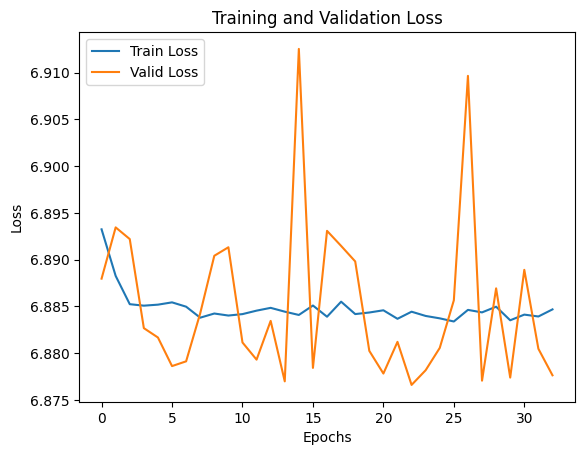

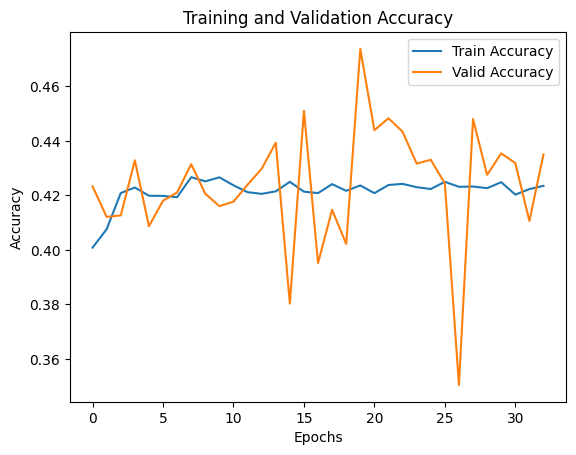

In [29]:
# Plotting the training and validation loss
epochs = range(len(train_list))

plt.plot(epochs, train_list, label='Train Loss')
plt.plot(epochs, valid_list, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


epochs = range(len(train_list))

plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, valid_acc_list, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [30]:
# Specify the file path to save the model#
#file_path = 'GNN_phylo_class.pt'

# Save the model
#torch.save(model.state_dict(), file_path)

In [18]:
#model.load_state_dict(torch.load('GNN_phylo_class.pt'))

<All keys matched successfully>

In [31]:
#test_dl = DataLoader(data_list[:500], batch_size = 1)
n_param = len(df_param)
pred_list, true_list = [[0,0,0,0] for n in range(n_param)], [[] for n in range(n_param)]
acc_sum = [0 ,0 ,0 ,0 ,0]
total_sum = [0 ,0 ,0 ,0 ,0]



model.eval()
for data in test_dl:
    out = model(data.to(device=device))
    pred_params = torch.argmax(out,dim=1)[0]
    true_params = torch.argmax(data.y,axis=0)

    acc = torch.sum(torch.argmax(data.y,axis=0)==torch.argmax(out,dim=1)[0]).item()


    pred_list[true_params][pred_params]+=1




    if (true_params == 0):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1

    elif (true_params == 1):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1
    
    elif (true_params == 2):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1
    
    elif (true_params == 3):
        acc_sum[true_params]    =   acc_sum[true_params] + acc
        total_sum[true_params]  =   total_sum[true_params] + 1

acc_sum[4]    =   sum(acc_sum[:-1])
total_sum[4]  =   sum(total_sum[:-1])





In [32]:
print(acc_sum)
print(total_sum)
print(pred_list)

[0, 460, 0, 410, 870]
[499, 515, 499, 488, 2001]
[[0, 423, 0, 76], [0, 460, 0, 55], [0, 88, 0, 411], [0, 78, 0, 410]]


In [33]:
result = [a / b if b != 0 else 0 for a, b in zip(acc_sum, total_sum)]

print("Accuracy pred CRBD: %.3f ,Bisse: %.3f ,DDD: %.3f ,PLD: %.3f ,Total: %.3f   " % tuple(result))


Accuracy pred CRBD: 0.000 ,Bisse: 0.893 ,DDD: 0.000 ,PLD: 0.840 ,Total: 0.435   


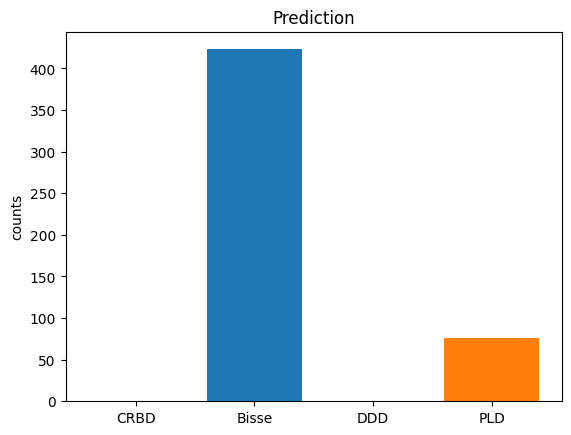

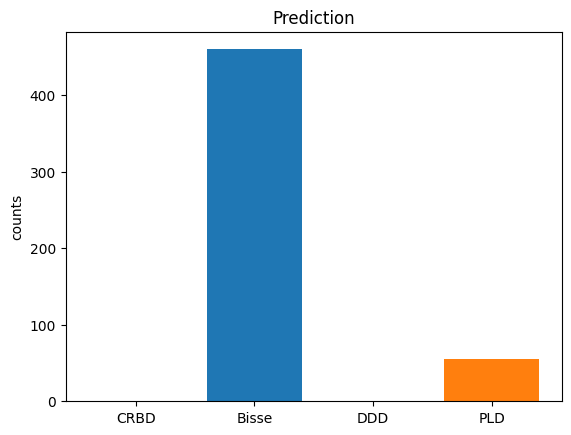

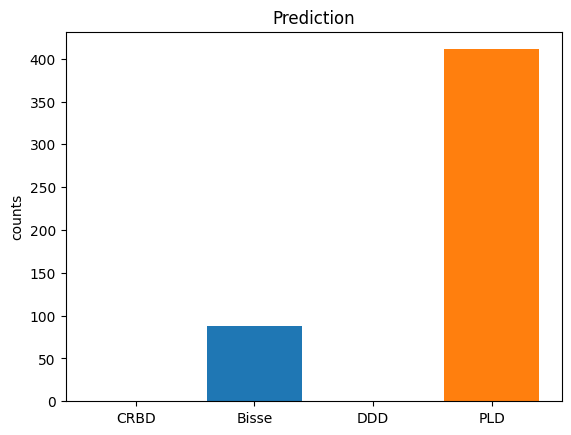

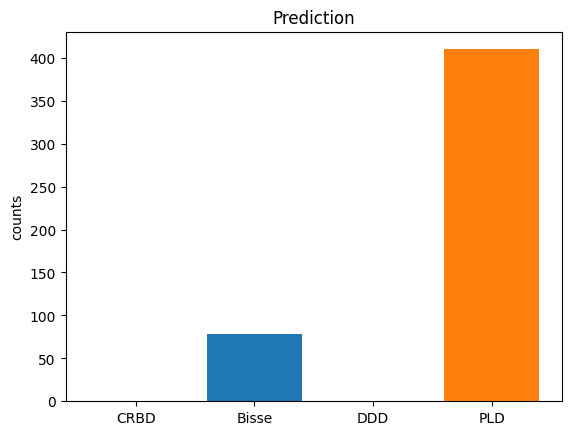

In [34]:
for i, sublist in enumerate(pred_list):
    fig, ax = plt.subplots()

    preds = ['CRBD', 'Bisse', 'DDD', 'PLD']
    counts = sublist
    bar_labels = ['red', 'blue', 'red', 'orange']
    bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

    ax.bar(preds, counts, color=bar_colors)

    ax.set_ylabel('counts')
    ax.set_title('Prediction')

    plt.show()

